# Решение тестового задания titanc на kaggle 
https://www.kaggle.com/competitions/titanic/overview

__Импортируем библиотеки__ 
+ pandas
+ numpy 
+ seaborn
+ sklearn

In [444]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import pylab 
import scipy.stats as stats

# Импорт и описание данных


In [416]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')

In [417]:
train_data.head(25)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


__pclass__: A proxy for socio-economic status (SES)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__1st__ = Upper   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__2nd__ = Middle    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__3rd__ = Lower    
__age__: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5  
__sibsp__: The dataset defines family relations in this way...  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__Sibling__ = brother, sister, stepbrother, stepsister  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__Spouse__ = husband, wife (mistresses and fiancés were ignored)  
__parch__: The dataset defines family relations in this way...  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__Parent__ = mother, father  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__Child__ = daughter, son, stepdaughter, stepson  
Some children travelled only with a nanny, therefore parch=0 for them.  

In [418]:
train_data.shape

(891, 12)

# Hypotheses 
1) Пол влияет на выживаемость 
2) Наличие систер и братьев влияет влияет на выживаемость 
3) Наличие родителей влияет влияет на выживаемость 
4) Цена билета влияет на виживаемсоть 

# Preprocessing  and EDA

In [419]:
y = train_data['Survived']
X = train_data.drop(columns='Survived')

## Name, PassengerId, Cabin

In [420]:
unique_name = len(X['Name'].unique())/len(X['Name'])
print(f'Отношение уникальных признаков к выборке в Name: {unique_name}')
unique_PassengerId = len(X['PassengerId'].unique())/len(X['PassengerId'])
print(f'Отношение уникальных признаков к выборке в PassengerId: {unique_PassengerId}')
unique_Ticket = len(X['Ticket'].unique())/len(X['Ticket'])
print(f'Отношение уникальных признаков к выборке в Ticket: {unique_Ticket}')

Отношение уникальных признаков к выборке в Name: 1.0
Отношение уникальных признаков к выборке в PassengerId: 1.0
Отношение уникальных признаков к выборке в Ticket: 0.7643097643097643


In [421]:
X.nunique() # уникальные признаки

PassengerId    891
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

__Порог, после которого признаки лучше выкидывать, зависит от задачи конечно, а в этом проекте я удалю  колонки, пустые более чем на половину. Поэтому избавимся от признака   
Cabin, так как у него болье поливы пропушенных значений. Целых 687 из 891. Также можно допнуть Name и PassengerId, так как каждый их празинков появляется для объектов один раз.__

In [422]:
X = X.drop(columns=['Cabin', 'Name', 'PassengerId', 'Ticket'])

## Fill NaN

__Теперь поработаем с пропущенными значениями. Они присутствуют в Age, Embarked. Для Age мы Nan заменим на среднее, так как, очевидно, нулевого возраста не бывает:)).   
А для   Embarked  все NaN заменим на 'NS' (аля not stated).__

In [423]:
X['Age'] = X['Age'].fillna(value=X['Age'].mean())
X['Embarked'] = X['Embarked'].fillna(value='NS')

In [424]:
train_data['Age'] = train_data['Age'].fillna(value=train_data['Age'].mean())
train_data['Embarked'] = train_data['Embarked'].fillna(value='NS')

In [425]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.910400
50%,3.000000,29.699118,0.000000,0.000000,14.454200
75%,3.000000,35.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


# Spearman's Correlation 

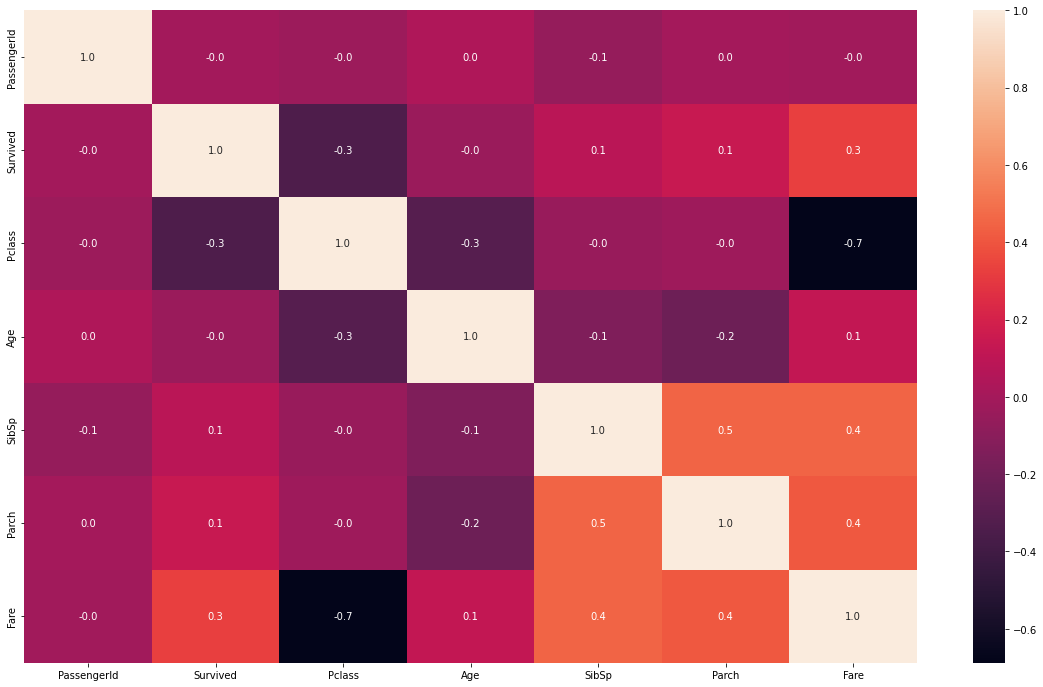

In [426]:
plt.figure(figsize=(20, 12))
sns.heatmap(train_data.corr(method='spearman'), annot=True, fmt='.1f')
plt.show()

## Target

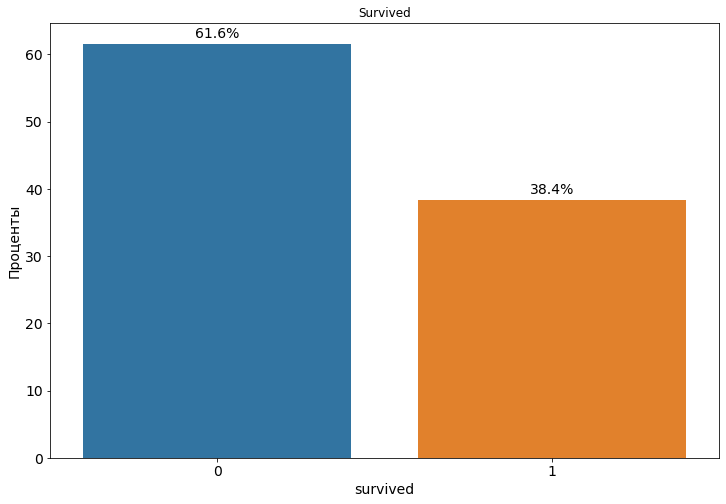

In [427]:
nomrlize_trget = y.value_counts(normalize=True).mul(100).rename('percent').reset_index()
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='index', y='percent', data=nomrlize_trget)
#В цикле смотрим каждый столбец графика и отемачем значение 
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    #annotate() - вывод значений над графиками 
    ax.annotate(percentage,
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=14
    )
plt.title('Survived')
plt.xlabel('survived', fontsize=14)
plt.ylabel('Проценты', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

__Классы не сбалансированны__

## Sex

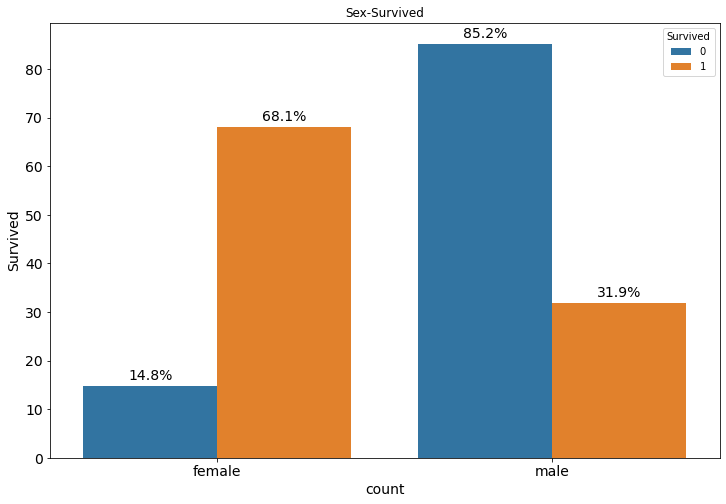

In [428]:
plt.figure(figsize=(12, 8))
sex_surv = (
    train_data.groupby(['Survived'])['Sex']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percentage')
    .reset_index()
    .sort_values('Sex')
)
ax = sns.barplot(x='Sex', y='percentage', data=sex_surv, hue='Survived')
#В цикле смотрим каждый столбец графика и отемачем значение 
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    #annotate() - вывод значений над графиками 
    ax.annotate(percentage,
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=14
    )
plt.title('Sex-Survived')
plt.xlabel('count', fontsize=14)
plt.ylabel('Survived', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Age

<Figure size 864x576 with 0 Axes>

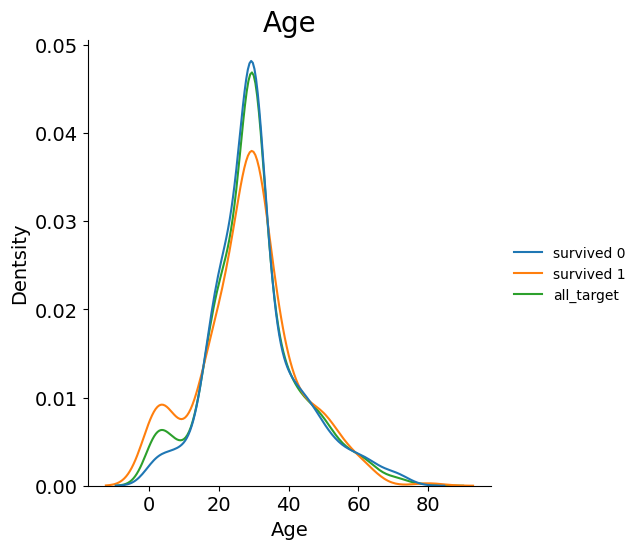

In [429]:
plt.figure(figsize=(12, 8))
ax = sns.displot(
    {
        'survived 0': train_data[train_data['Survived'] == 0]['Age'],
        'survived 1': train_data[train_data['Survived'] == 1]['Age'],
        'all_target': train_data['Age']
    },
    kind='kde',
    #независимая нормализация каждого подмножества
    common_norm=False
)
ax.fig.set_dpi(100)
plt.title('Age', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

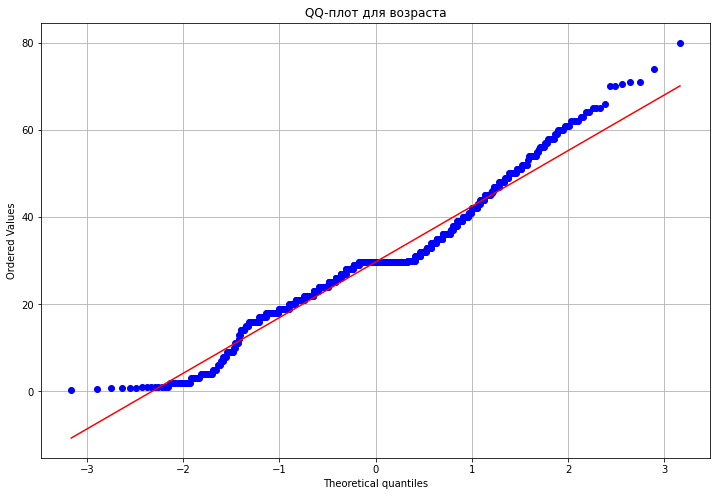

Тест Шапиро-Уилкинса
P_value:3.972714542180072e-15
statistic :0.9588214159011841


In [430]:
plt.figure(figsize=(12, 8))
plt.grid(True)
stats.probplot(X['Age'], dist="norm", plot=pylab)
plt.title('QQ-плот для возраста')
pylab.show()
statistic, p_value = stats.shapiro(x=X['Age'])
print('Тест Шапиро-Уилкинса')
print(f'P_value:{p_value}')
print(f'statistic :{statistic}')

## SibSp, Parch

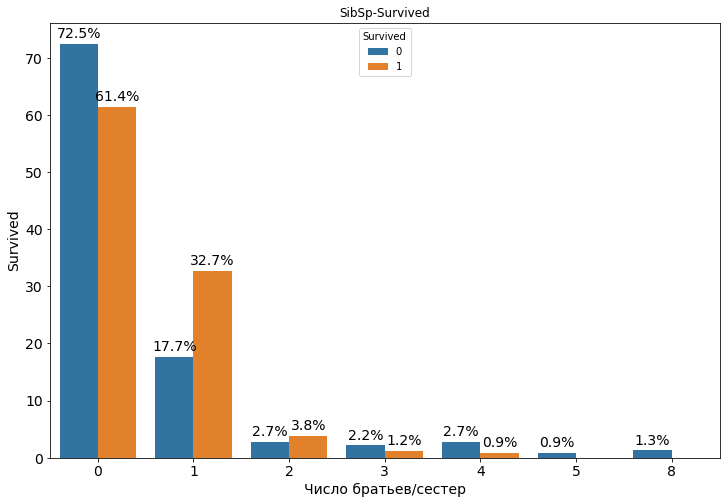

In [431]:
plt.figure(figsize=(12, 8))
SibSp_surv = (
    train_data.groupby(['Survived'])['SibSp']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percentage')
    .reset_index()
    .sort_values('SibSp')
)
ax = sns.barplot(x='SibSp', y='percentage', data=SibSp_surv, hue='Survived')
#В цикле смотрим каждый столбец графика и отемачем значение 
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    #annotate() - вывод значений над графиками 
    ax.annotate(percentage,
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=14
    )
plt.title('SibSp-Survived')
plt.xlabel('Число братьев/сестер', fontsize=14)
plt.ylabel('Survived', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

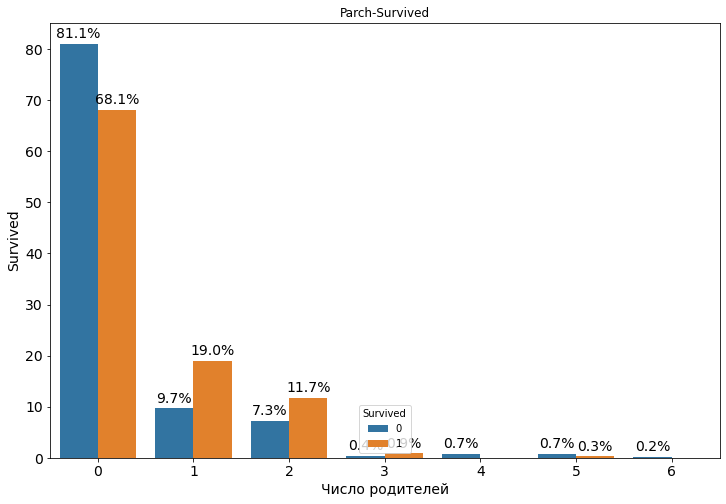

In [432]:
plt.figure(figsize=(12, 8))
Parch_surv = (
    train_data.groupby(['Survived'])['Parch']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percentage')
    .reset_index()
    .sort_values('Parch')
)
ax = sns.barplot(x='Parch', y='percentage', data=Parch_surv, hue='Survived')
#В цикле смотрим каждый столбец графика и отемачем значение 
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    #annotate() - вывод значений над графиками 
    ax.annotate(percentage,
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=14
    )
plt.title('Parch-Survived')
plt.xlabel('Число родителей', fontsize=14)
plt.ylabel('Survived', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

__На основе фичей Parch и SibSp сделаем новую: Relatives, как  сумму последних двух.__


In [433]:
train_data['Relatives'] = train_data.apply(lambda row: row['Parch'] + row['SibSp'], axis=1)

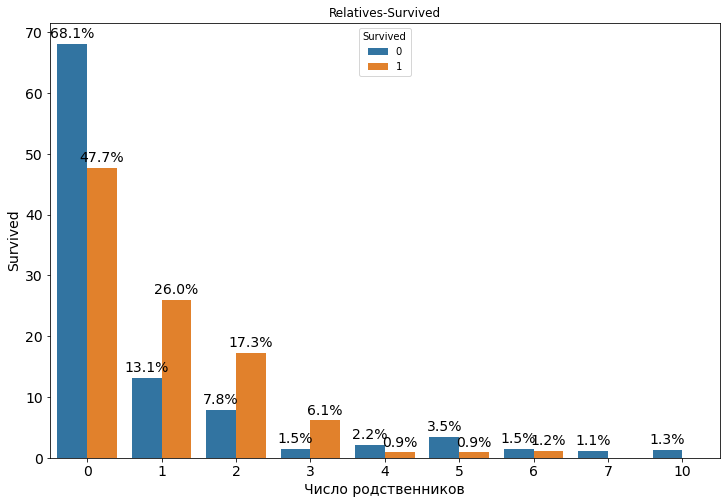

In [434]:
plt.figure(figsize=(12, 8))
Relatives_surv = (
    train_data.groupby(['Survived'])['Relatives']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percentage')
    .reset_index()
    .sort_values('Relatives')
)
ax = sns.barplot(x='Relatives', y='percentage', data=Relatives_surv, hue='Survived')
#В цикле смотрим каждый столбец графика и отемачем значение 
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    #annotate() - вывод значений над графиками 
    ax.annotate(percentage,
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=14
    )
plt.title('Relatives-Survived')
plt.xlabel('Число родственников', fontsize=14)
plt.ylabel('Survived', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

__Удалим Parch и SibSp, оставив  Relatives, убрав из таблицы данные c Relatives > 4__

In [435]:
X['Relatives'] = X.apply(lambda row: row['Parch'] + row['SibSp'], axis=1)
X = X.drop(columns=['Parch', 'SibSp'])
X = X.loc[X['Relatives'] < 4]

In [484]:
train_data['Relatives'] = train_data.apply(lambda row: row['Parch'] + row['SibSp'], axis=1)
train_data = train_data.drop(columns=['Parch', 'SibSp'])
train_data = train_data.loc[train_data['Relatives'] < 4]
y = train_data['Survived']

## Fare

C:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 864x576 with 0 Axes>

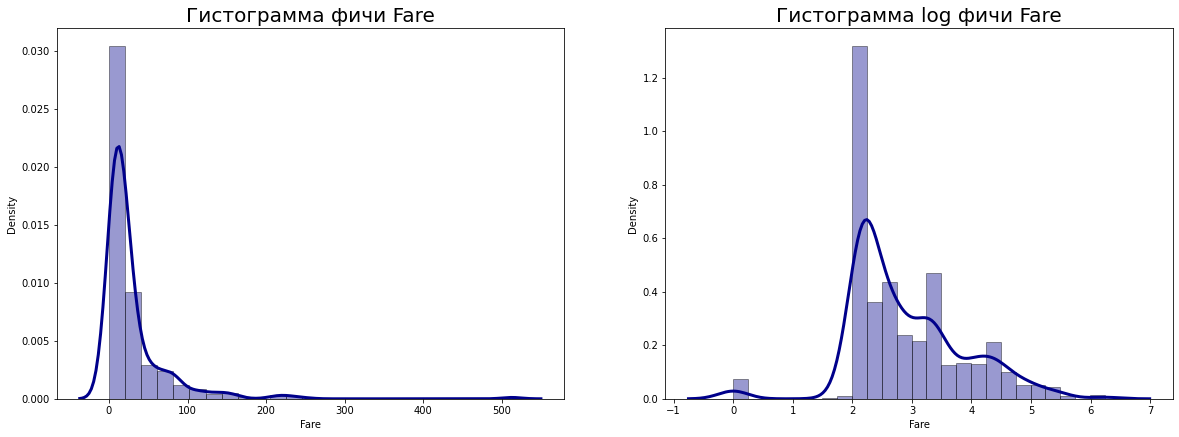

In [436]:
plt.figure(figsize=(12, 8))
fig = plt.figure(figsize=(20, 15))
ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)
sns.distplot(
    X['Fare'], hist=True, kde=True, 
    bins=25, color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 3}, ax=ax_1)
sns.distplot(
    np.log(X['Fare'] + 1), hist=True, kde=True, 
    bins=25, color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 3}, ax=ax_2)

ax_1.set_title('Гистограмма фичи Fare', fontsize=20)
ax_2.set_title('Гистограмма log фичи Fare', fontsize=20)
plt.show()

__Видно, что для гистограммы Fare характерены несбалансированные расапеделения с выбросам, в особенности для стоимостей билетов. Логарифм улучшил эту ситуацию.__

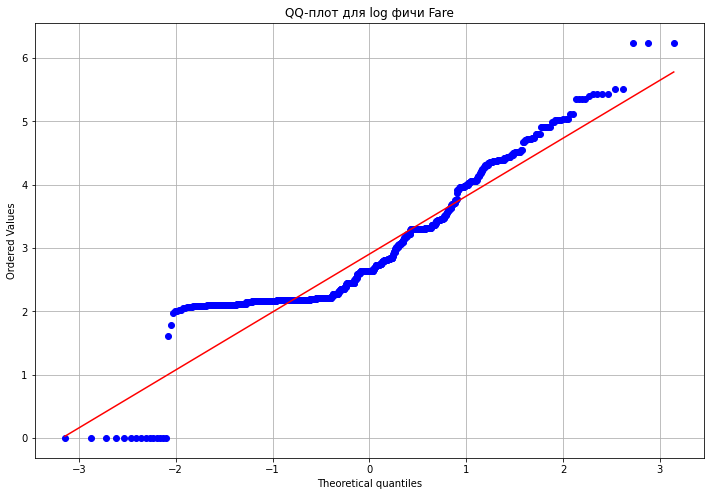

In [437]:
plt.figure(figsize=(12, 8))
plt.grid(True)
stats.probplot(np.log(X['Fare']+1), dist="norm", plot=pylab)
plt.title('QQ-плот для log фичи Fare')
pylab.show()

In [438]:
X['Fare'] = np.log(X['Fare'] + 1)

# Проведем one-hot encoding для Sex и Embarked и Standardization 

In [469]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [470]:
# ColumnTransformer - применяет трансформаторы к столбцам массива или pandas DataFrame
# transformers = [('cat', OneHotEncoder(), [1, 4]), ...] - 'cat' - название, OneHotEncoder() - тип препроцесинга, [1, 4] - номер стобца (тут Sex - 1 и Embarked - 4 )
column_transformer = ColumnTransformer(transformers = [('cat', OneHotEncoder(), [1, 4]), ('stand', StandardScaler(), [2, 3, 5])], remainder = 'passthrough')
X_transformed = np.array(column_transformer.fit_transform(X))

# Модели машинного обучения 

In [521]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve, average_precision_score

In [480]:
K_FOLD = 3
TEST_SIZE = 0.25

In [490]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=TEST_SIZE)

In [522]:
lg_regressor = LogisticRegression(class_weight='balanced')
svm_classifier = SVC(class_weight='balanced', probability=True)
rf_classifier = RandomForestClassifier(class_weight='balanced')
gb_classifer = GradientBoostingClassifier()

In [523]:
lg_regressor.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)
gb_classifer.fit(X_train, y_train)

GradientBoostingClassifier()

In [541]:
predict_tuple = (
    lg_regressor.predict(X_test),
    svm_classifier.predict(X_test),
    rf_classifier.predict(X_test),
    gb_classifer.predict(X_test)
)

proba_tuple = (
    lg_regressor.predict_proba(X_test)[:, 1],
    svm_classifier.predict_proba(X_test)[:, 1],
    rf_classifier.predict_proba(X_test)[:, 1],
    gb_classifer.predict_proba(X_test)[:, 1]
)

models_name = (
    'LogisticRegression',
    'svm_classifier',
    'RandomForestClassifier',
    'GradientBoostingClassifier'
)

In [543]:
for proba, name in zip(proba_tuple, models_name):
    print(f'ROC AUC SCORE for {name}: {roc_auc_score(y_true=y_test, y_score=proba)}')
print('------------------------------------------------------------------')


for proba, name in zip(proba_tuple, models_name):
    print(f'PR AUC SCORE for {name}: {average_precision_score(y_true=y_test, y_score=proba)}')
print('------------------------------------------------------------------')


for proba, name in zip(proba_tuple, models_name):
    print(f'PR AUC SCORE for {name}: {average_precision_score(y_true=y_test, y_score=proba)}')
print('------------------------------------------------------------------')


for pred, name in zip(predict_tuple, models_name):
    print(f'F1 SCORE for {name}: {f1_score(y_true=y_test, y_pred=pred)}')
print('------------------------------------------------------------------')



for pred, name in zip(predict_tuple, models_name):
    print(f'ACCURACY SCORE for {name}: {accuracy_score(y_true=y_test, y_pred=pred)}')
print('------------------------------------------------------------------')



ROC AUC SCORE for LogisticRegression: 0.8575059808612441
ROC AUC SCORE for svm_classifier: 0.8466407496012759
ROC AUC SCORE for RandomForestClassifier: 0.8741527113237639
ROC AUC SCORE for GradientBoostingClassifier: 0.8826754385964913
------------------------------------------------------------------
PR AUC SCORE for LogisticRegression: 0.8163128129541362
PR AUC SCORE for svm_classifier: 0.7578774026487766
PR AUC SCORE for RandomForestClassifier: 0.8531826340212882
PR AUC SCORE for GradientBoostingClassifier: 0.859441131595617
------------------------------------------------------------------
PR AUC SCORE for LogisticRegression: 0.8163128129541362
PR AUC SCORE for svm_classifier: 0.7578774026487766
PR AUC SCORE for RandomForestClassifier: 0.8531826340212882
PR AUC SCORE for GradientBoostingClassifier: 0.859441131595617
------------------------------------------------------------------
F1 SCORE for LogisticRegression: 0.7532467532467534
F1 SCORE for svm_classifier: 0.7448275862068965
F

[]

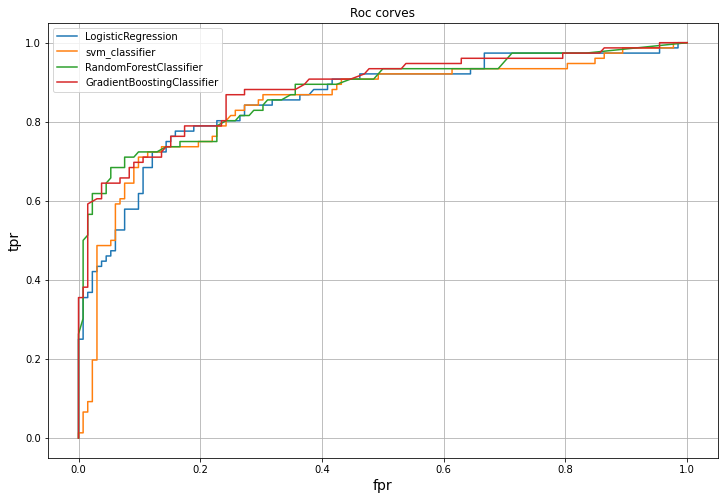

In [551]:
plt.figure(figsize=(12, 8))
plt.grid(True)
for proba, name in zip(proba_tuple, models_name):
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=proba)
    plt.plot(fpr, tpr, label=name)

plt.legend()
plt.xlabel('fpr', fontsize=14)
plt.ylabel('tpr', fontsize=14)
plt.title('Roc curves')
plt.plot()

[]

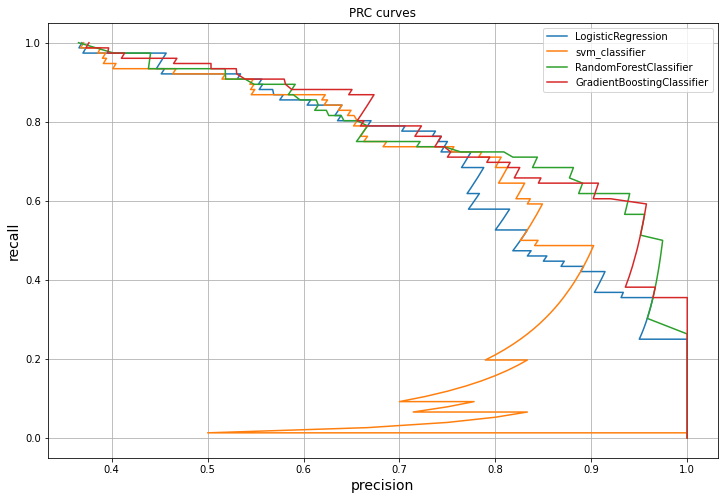

In [554]:
plt.figure(figsize=(12, 8))
plt.grid(True)
for proba, name in zip(proba_tuple, models_name):
    pr, rec, _ = precision_recall_curve(y_true=y_test, probas_pred=proba)
    plt.plot(pr, rec, label=name)

plt.legend()
plt.xlabel('precision', fontsize=14)
plt.ylabel('recall', fontsize=14)
plt.title('PRC curves')
plt.plot()